# CAB420, Diarisation (or Metric Learning and Clustering Combined)
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

This example revisits our clustering mehods and explores an application of metric learning and clustering: Speaker Diarisation. 

Speaker Diarisation is the problem of working out "who spoke when". A full blown speaker diarisation system has quite a few moving parts. A complete pipeline may include:
* A speech activity detection module, that finds regions of speech in an audio recording
* A speaker change detection module, that detects when the speaker changes (this component may or may not exist depending on the approach)
* A speaker recognition engine, that extracts a vector (i.e. an embedding) to represent each section of speech
* A clustering method, that groups segments of speech into those that are spoken by the same speaker

We're going to ignore the first step (and the optional second step) and take the segmentation information directly from the annotation. We'll address the second last part (speaker recognition) using metric learning where we can train a model to get embeddings for the speakers. For clustering we'll try both K-means and GMM (though we expect the GMM to work better).

In [1]:
import xml.etree.ElementTree as ET
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy
import random

import keras
from keras import layers
from keras import backend as K
import librosa

from sklearn.manifold import TSNE

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

import glob

## The Data

We're using a small portion of the [ICSI Meeting Corpus](https://groups.inf.ed.ac.uk/ami/icsi/). I have avoided using the full corpus here to keep the example more compact, and also to allow me to use a simpler parser to load the data. I have also encoded the wav files provided with the corpus into MP3s. This makes the data much more compact, but also makes the loading and decoding process much slower. This data contains meeting room recordings, all of which are annotated with the IDs of people speaking over time, as well as the speech content (i.e. what they said).

Annotation data is broken into several files. Here, we're only concerned with the speech segmentation annotation, which captures who's speaking, and at what times. The annotation contains a lot more information (such as what was said) which we'll totally ignore. We'll also greatly simplify the problem by:
* Ignoring any non-speech vocalisations
* Ignoring any small (by default less than 1 second) speech segments
* Truncating all other speech segments to just the first second

This means that we'll simply end up comparing 1 second speech segments. Using such small segments (often referred to as *utterances* in the speaker rec literature) is less than ideal as these contain less information from which to recognise someone, but having this segment length too long will mean too few samples in our simplified pipeline.

We'll also convert our speech segments to images, in the form of spectrograms. Spectograms visualise frequency over time, and work well when dealing with audio. In general, representations that capture frequency information work well with audio data.

#### XML Annotation Data

**NOTE:** The below function is doing a bunch of XML parsing to load the annotation. This is not super important to understand, and if you're not familar with XML (or YAML, or similar markup languages) that's ok. If you have questions about what is being done here, please feel free to reach out and ask.

A snippet of an XML file is below:
```
<?xml version="1.0" encoding="ISO-8859-1" standalone="yes"?>
<nite:root nite:id="Bed005.C.segs" xmlns:nite="http://nite.sourceforge.net/">
   <segment nite:id="Bed005.segment.2" starttime="10.8" endtime="11.525" participant="mn015" timing-provenance="segment">
      <nite:child href="Bed005.C.words.xml#id(Bed005.vocalsound.1)"/>
   </segment>
   <segment nite:id="Bed005.segment.4" starttime="13.261" endtime="15.016" participant="mn015" timing-provenance="segment">
      <nite:child href="Bed005.C.words.xml#id(Bed005.vocalsound.3)"/>
   </segment>
   <segment nite:id="Bed005.segment.6" starttime="16.261" endtime="17.266" participant="mn015" timing-provenance="segment">
      <nite:child href="Bed005.C.words.xml#id(Bed005.nonvocalsound.1)"/>
   </segment>
   <segment nite:id="Bed005.segment.8" starttime="17.309" endtime="20.1" participant="mn015" timing-provenance="segment">
      <nite:child href="Bed005.C.words.xml#id(Bed005.vocalsound.4)"/>
   </segment>
   <segment nite:id="Bed005.segment.12" starttime="20.656" endtime="40.352" participant="mn015" timing-provenance="segment">
      <nite:child href="Bed005.C.words.xml#id(Bed005.vocalsound.6)"/>
   </segment>
   <segment nite:id="Bed005.segment.17" starttime="40.761" endtime="42.529" participant="mn015" timing-provenance="segment">
      <nite:child href="Bed005.C.words.xml#id(Bed005.vocalsound.8)"/>
   </segment>
```

From this, you can see that:
* We have a collection of *segments*. Each segment is a bit of audio that contains a particular speaker making a sound
* Segments have start and end times. These are in seconds, rather than samples. This means that when parsing data we need to convert from seconds into raw audio samples, and thus we need to know the sampling rate. They also have a "timing-provenance", which helps us work out which segments contain speed and which don't.
* The child *href* tag contains a link to other annotation data (such as the transcription). We don't care about this.

In [2]:
# Parse a meetings data, a meeting has
# - an audio file, which contains the meeting content
# - a collection of annotation files. In particular, there is one XML file per speaker indicating when they speak
# This function take the input audio file and a glob that captures all the XML and collect segments of speech for
# each instance of each person speaking. Extracted speech will be stored as a spectrogram, rather than as raw speech.
#
# This function will return two lumps of data
# - the set of extracted segments of speech. Each of these will be segment_length seconds long and have been converted
#   to a spectrogram
# - the annotation data for the sequence, which will be used for visualisation and evaluation later on. This will contain
#   overall data about the sequence (i.e. it's length) and data for each segment, even those that are ignored for being too
#   short or non-vocal sounds
#
def parse_meeting(audio_file, annotation_glob, sample_rate = 16000, segment_length = 1, store_raw_audio = False):

    # extracted segments and annotation
    extracted_segments = []
    annotation = {}
    
    # load the audio file
    # use librosa to load audio. I could use tf and tfio here for this as well, though I've found
    # some version challenges (or perhaps inconsistencies) with these options, and have chosen librosa
    # for it's stablity
    audio, sr = librosa.load(audio_file)

    # if I was going to use tf and tfio, I would do something like the following
    # load the file
    # audio_binary = tf.io.read_file(audio_file)
    # decode the mp4 file into the raw samples, returns the audio itself and the sampling rate
    # audio, sr = tfio.audio.decode_mp3(audio_binary)
    # reshape
    # audio = tf.squeeze(audio, axis=-1)
    
    # if needed, resample the data
    if (sr != sample_rate):
        audio = librosa.resample(audio, orig_sr = sr, target_sr = sample_rate)

    # convert to float32
    audio = tf.cast(audio, tf.float32)

    # overall information about the audio
    annotation['length'] = audio.shape[0]
    annotation['sample_rate'] = sample_rate
    annotation['speakers'] = []
    annotation['segments'] = []

    # get the list of annotation files to process
    annotation_files = glob.glob(annotation_glob)
        
    # loop through the annotation
    for f in annotation_files:
        # annotation files are all XML, parse these and get the root element
        tree = ET.parse(f)
        root = tree.getroot()
        # each speech segment is within a segment tag, find all of these
        segments = root.findall('segment')
        # grab the unique ID of the participant in this file
        annotation['speakers'].append(segments[0].attrib['participant'])

        # loop through all the segments
        for s in segments:
            
            # get the start and end time. In the annotation these are defined in seconds, convert that into
            # samples by multiplying by the sampling rate
            start = int(float(s.attrib['starttime'])*sample_rate)
            end = int(float(s.attrib['endtime'])*sample_rate)
            # get the segment length
            length = end - start

            # store the information about the segment, note that at the moment the id is set to None. If we discard
            # this segment for some reason the id of None will indicate to later steps that this is a speech segment
            # that we are ignoring
            an = {}
            an['start'] = start
            an['end'] = end
            an['id'] = None

            # get the child attributes of the current segment
            
            # there is a 'timing-provenance' attribute which indictates the type of utterance we're looking at.
            # Check if this is a dialogueact, indicating that there's speech involved. Any non-speech signal is
            # just going to be ignored 
            if ('timing-provenance' in s.attrib.keys()):
                if (s.attrib['timing-provenance'] == 'dialogueact'):
                    # check the length, if the sample is too small, ignore it
                    if (length >= sample_rate*segment_length):

                        # pull out the segment
                        seg = {}
                        if store_raw_audio:
                            seg['audio'] = audio[start:(start + int(sample_rate*segment_length))]

                        # convert it to a spectrogram
                        seg['spectrogram'] = tf.abs(tf.signal.stft(audio[start:(start + int(sample_rate*segment_length))], \
                                                                   frame_length=255, frame_step=128))
                        # store the segment
                        seg['id'] = s.attrib['participant']
                        seg['start'] = start
                        seg['end'] = end
                        extracted_segments.append(seg)

                        # update the ID in the annotation data as we're going to use this segment
                        an['id'] = s.attrib['participant']
            
            annotation['segments'].append(an)
                    
    # return the extracted data, and the annotation
    return extracted_segments, annotation

We'll now load a bunch of meeting files. We'll use the first four for training, and the last two for testing.

In [3]:
# load data for a bunch of meetings
segments_bed002, annotation_bed002 = parse_meeting('../data/ICSI_Segment/Bed002/Bed002.interaction.mp3',
                                                   '../data/ICSI_Segment/Bed002/*.xml')
segments_bed003, annotation_bed003 = parse_meeting('../data/ICSI_Segment/Bed003/Bed003.interaction.mp3',
                                                   '../data/ICSI_Segment/Bed003/*.xml')
segments_bed004, annotation_bed004 = parse_meeting('../data/ICSI_Segment/Bed004/Bed004.interaction.mp3',
                                                   '../data/ICSI_Segment/Bed004/*.xml')
# NOTE: I've skipped meeting 5 here. There is some added complexity in the child elements in the XML here, and rather
# than make my XML parser more robust I've simply skipped this file.
#segments_bed005, annotation_bed005 = parse_meeting('../data/ICSI_Segment/Bed005/Bed005.interaction.wav',
#                                                   '../data/ICSI_Segment/Bed005/*.xml')
segments_bed006, annotation_bed006 = parse_meeting('../data/ICSI_Segment/Bed006/Bed006.interaction.mp3',
                                                   '../data/ICSI_Segment/Bed006/*.xml')
segments_bed008, annotation_bed008 = parse_meeting('../data/ICSI_Segment/Bed008/Bed008.interaction.mp3',
                                                   '../data/ICSI_Segment/Bed008/*.xml')
segments_bed009, annotation_bed009 = parse_meeting('../data/ICSI_Segment/Bed009/Bed009.interaction.mp3',
                                                   '../data/ICSI_Segment/Bed009/*.xml')

### Visualising the Data

We'll create a simple function to visualise an audio file as a colour coded timeline. As these audio files are quite long (an hour or so), this will still be quite busy, but it will give us a way to look at who's speaking when. We'll use black to denote no speaking, a middle-gray to indicate the instances where `id == None` that correspond to bits of audio we've ignored for one reason or another, and then other random colours to indicate each speaker.

Note that colours do not necessarily correspond across files. Some of these files share the same speakers, some do not, and considering that is outside the scope of this example

In [4]:
# Draw a timeline image to indicate what's happening in the file. Downsample the audio by some factor when drawing the 
# timeline to help make the scale a bit easier to look at.
#
def draw_annotation(annotation, height = 400, downsample = 10000, seed = 42):
    # pick some random colours
    r = numpy.random.default_rng(seed)
    colours = r.integers(0, 256, (len(annotation['speakers']), 3))
    
    # create the timeline image
    markup = numpy.zeros((height, annotation['length']//downsample, 3))
    
    # loop through each segmentation of annotation
    for a in annotation['segments']:
        # if it's a segment we're ignoring, set the colour to a middle gray
        if (a['id'] is None):
            markup[:, (a['start']//downsample):(a['end']//downsample), :] = 128
        else:
            # otherwise, set the colour to one that corresponds to the speaker
            c = annotation['speakers'].index(a['id'])
            markup[:, (a['start']//downsample):(a['end']//downsample), :] = colours[c, :]

    # return the marked-up timeline image
    return markup.astype('int')

Now we'll visualise some files. These are the four that we'll use for training.

Text(0.5, 1.0, 'Bed006')

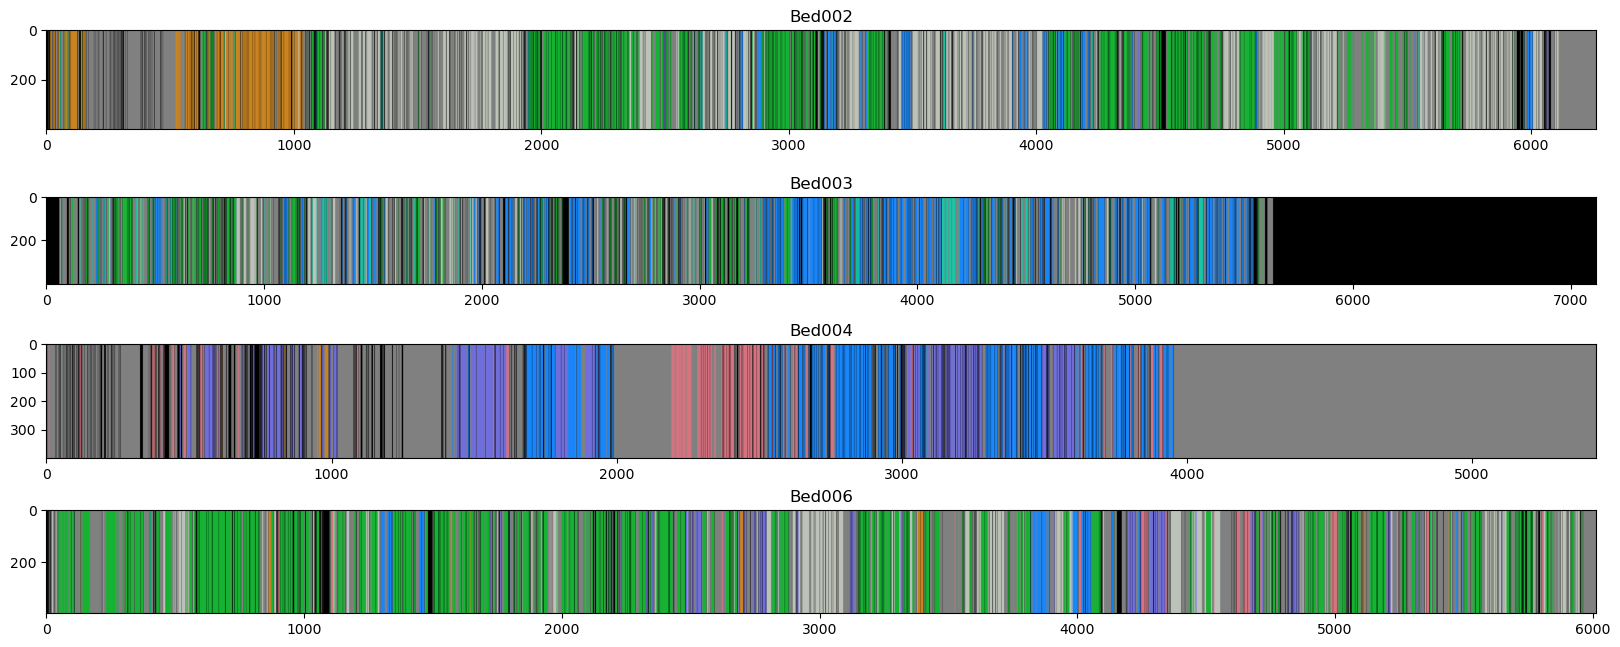

In [5]:
fig, axes = plt.subplots(4, figsize=(20, 8))
markup = draw_annotation(annotation_bed002)
axes[0].imshow(markup)
axes[0].set_title('Bed002')
markup = draw_annotation(annotation_bed003)
axes[1].imshow(markup)
axes[1].set_title('Bed003')
markup = draw_annotation(annotation_bed004)
axes[2].imshow(markup)
axes[2].set_title('Bed004')
markup = draw_annotation(annotation_bed006)
axes[3].imshow(markup)
axes[3].set_title('Bed006')

We can see each file contains a few different speakers, but in each case one or two speakers tends to dominate the conversation.

### Training Data

Our training data is simply all the segments for the from the first four files, so we'll simply append those lists.

In [6]:
training = segments_bed002 + segments_bed003 + segments_bed004 + segments_bed006

We'll use a triplet network to train our speaker recognition approach. Triplet generation functions are copied below from the ealier example, and adapted to work with our list of samples.

In [7]:
def GetTripletData(samples, batch_size):

    # storage for triplets
    image_a = numpy.zeros((batch_size, samples[0]['spectrogram'].shape[0], samples[0]['spectrogram'].shape[1], 1))
    image_b = numpy.zeros((batch_size, samples[0]['spectrogram'].shape[0], samples[0]['spectrogram'].shape[1], 1));
    image_c = numpy.zeros((batch_size, samples[0]['spectrogram'].shape[0], samples[0]['spectrogram'].shape[1], 1));
    
    for i in range(batch_size):

        # select some indexes at random
        idx1 = random.randint(0, len(samples) - 1)
        idx2 = random.randint(0, len(samples) - 1)
        idx3 = random.randint(0, len(samples) - 1)

        # make sure that idx1 and idx2 belong to the same subject (anchor and positive)
        while (samples[idx1]['id'] != samples[idx2]['id']):
            idx2 = random.randint(0, len(samples) - 1)
                
        # make sure that idx1 and idx3 belong to different subjects (anchor and negative)
        while (samples[idx1]['id'] == samples[idx3]['id']):
            idx3 = random.randint(0, len(samples) - 1)

        image_a[i, :, :, 0] = samples[idx1]['spectrogram']
        image_b[i, :, :, 0] = samples[idx2]['spectrogram']
        image_c[i, :, :, 0] = samples[idx3]['spectrogram']

    return [image_a, image_b, image_c]

### Speaker Recognition Network

Now we'll build our simple backbone network. As per earlier examples, we're using our simple VGG network builder functions.

In [8]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

And now we'll setup our triplet network. Again, this is very like what we've used in the past. We'll take our input, pass it through a simple VGG-like network, pull out an embedding, and then compare those embeddings in the triplet loss function to train our embedding space. 

The one difference here is that we've added a resize layer after the input, which will resize our spectogram down to a nice and manageable 32x32 image. As always, there is a trade-off here between complexity and performance. Keeping this bigger would help retain more information and improve performance, though we'd likely also need more data if we did so.

In [9]:
embedding_size = 32
# get input shape based on the size of the spectrogram
input_shape = (training[0]['spectrogram'].shape[0], training[0]['spectrogram'].shape[1], 1)

# create dummy input, and pass this through a resize layer
dummy_input = keras.Input(input_shape)
resized_input = layers.Resizing(32, 32)(dummy_input)
# create the backbone network, and pass the resized input through this
base_network = vgg_net(resized_input, [8, 16, 32], [256], 0.2, 0)
# get the final embedding
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)

# create the backbone network
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

In [10]:
def normalise_vector(vect):
    # get the magnitude for each vector in the batch
    mag = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vect), axis=1))
    # repeat this, so we now have as many elements in mag as we do in vect
    mag = keras.ops.reshape(keras.ops.repeat(mag, vect.shape[1], axis=0), (-1, vect.shape[1]))
    # element wise division
    return keras.ops.divide(vect, mag)

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = normalise_vector(anchor)
        positive = normalise_vector(positive)
        negative = normalise_vector(negative)

        p_dist = keras.ops.sum(keras.ops.square(anchor-positive), axis=-1)
        n_dist = keras.ops.sum(keras.ops.square(anchor-negative), axis=-1)
        return keras.ops.sum(keras.ops.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
# create the three inputs for the anchor, positive and negative samples
input_anchor = keras.Input(input_shape, name='Anchor')
input_positive = keras.Input(input_shape, name='Positive')
input_negative = keras.Input(input_shape, name='Negative')

# pass each through the backbone
embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

# pass the embeddings through the triplet loss
margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)

Now we can train the network.

In [11]:
triplet_network.compile(optimizer=keras.optimizers.Adam(), jit_compile=False)

batch_size = 32
# quite a small number of samples here - pre-creating triplets is less than ideal
triplet_train_x = GetTripletData(training, 5000)

triplet_network.fit(x = triplet_train_x, y = None, batch_size = batch_size, epochs=20, validation_data=None)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - loss: 31.8867
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 28.3086
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 26.2588
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 24.6615
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 23.7250
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.3292
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.3611
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.9298
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 13.7650
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 13.7795
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11.6790
Epoch 12/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11.8098
Epoch 13/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10.5355
Epoch 14/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.8638
Epoch 15/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1

### Performing Diarisation

At this point, we've trained our speaker recognition backbone, and we can use this (with the help of a clustering method) to perform diarisation. Before we do that, we've got some utility functions to help us on our way:
* `get_testing_set`: A function to pull out all the segments and ground truth labels for a meeting to pass through as a testing set
* `draw_predictions`: A function to draw the predictions, in much the same way that we drew the ground truth above, but now using the results of the clustering (diarisation)
* `assign_labels`: A function to align the labels from the ground truth and diarisation results.

It's this last one that will cause the most confusion. 

#### An Aside: Finding the Optimal Assignments

To explain what `assign_labels` is doing, consider that we have three speakers (A, B and C), and we've grouped their audio segments into three clusters (1, 2 and 3) as follows:
```
    |    A|     B|     C|
    ---------------------
1   |    0|   100|     0|
2   |    0|     0|   100|
3   |  100|     0|     0|
```
From the above perfect assignment, we can clearly see that:
* Speaker B is captured by class 1
* Speaker C is captured by class 2
* Speaker A is captured by class 3

What we'd like is a way to pull that assignment out from the results automatically. To do this, we can use the Hungarian Algorithm which will determine the optimum set of assignments to minimise some cost. For this to work, we need to transform the above matrix (which is essentially a confusion matrix) into a cost matrix, which we can do by normalising the matrix and then subtracting the resultant normalised values from one. To help explain, we'll consider a less perfect set of assignments:
```
    |    A|     B|     C|
    ---------------------
1   |    5|    90|     5|
2   |   25|    25|    50|
3   |   75|     5|    20|
```
If we normalise these such that each row sums to one, we get:
```
    |    A|     B|     C|
    ---------------------
1   | 0.05|   0.9|  0.05|
2   | 0.25|  0.25|   0.5|
3   | 0.75|  0.05|   0.2|
```
And then if we subtract each value from one we get:
```
    |    A|     B|     C|
    ---------------------
1   | 0.95|  0.05|  0.95|
2   | 0.75|  0.75|   0.5|
3   | 0.25|  0.95|   0.8|
```
This is our cost matrix. 

If we assign the classes correctly, and match speaker B to class 1 (cost of 0.05), speaker C to class 2 (cost of 0.5) and speaker A to class 3 (cost of 0.25) our total cost is 0.8 (0.05 + 0.5 + 0.25). If we make a less optimal assignment, and instead match speaker A to class 1 (cost of 0.95), speaker B to class 2 (cost of 0.75) and speaker C to class 3 (cost of 0.8) our total cost is 2.5 (0.95 + 0.75 + 0.8).

Within `assign_labels` we'll use the hungarian algorithm to find the optimal set of assignments that minimise our overall cost. It's important to note that this is not going to impact the results of our diarisation, which is driven by our speaker recognition model, and the accuracy of our clustering. All this is doing is lining up the assigned clusters with the actual speaker labels in the best way possible, to help visualise performance (so that the same speaker has the same ID/colour in the visualiastion).

In [12]:
# pull out the samples, and ground truth labels, for each audio segment in a meeting
def get_testing_set(annotation, segments):
    data = []
    labels = []
    # loop through the semgnts
    for s in segments:
        # pull out the spectrogram and speaker ID
        data.append(s['spectrogram'])
        labels.append(annotation['speakers'].index(s['id']))

    # expand data array such that it's suitable to pass through a DCNN
    data = numpy.expand_dims(numpy.array(data), axis=3)

    # return data and labels
    return data, labels

# draw predictions as a timeline image to indicate what's happening in the file. Downsample the audio by some factor 
# when drawing the timeline to help make the scale a bit easier to look at.
#
def draw_predictions(labels, annotation, height = 400, downsample = 10000, seed = 42):
    # create some colours
    r = numpy.random.default_rng(seed)
    colours = r.integers(0, 256, (len(annotation['speakers']), 3))

    # create a markup image
    markup = numpy.zeros((height, annotation['length']//downsample, 3))
    count = 0

    # loop through the segments
    for a in annotation['segments']:
        # mark-up non-audio segments as a middle gray
        if (a['id'] is None):            
            markup[:, (a['start']//downsample):(a['end']//downsample), :] = 128
        # markup anything else as a pretty colour
        else:
            markup[:, (a['start']//downsample):(a['end']//downsample), :] = colours[labels[count], :]
            count = count + 1
    
    return markup.astype('int')

# label assignment function, using the hungarian algorithm
def assign_labels(gt, labels, verbose=False):
    
    # create the cost matrix, which is 1 - the normalised confusion matrix
    cost_matrix = 1.0 - confusion_matrix(gt, labels, normalize='pred')
    # perform the hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix.transpose())
    
    if (verbose == True):
        for a,b in zip(row_ind, col_ind):
            print('GT %d -> Pred %d' % (a, b))
    
    # extract and return the assigned labels
    assigned_labels = [col_ind[s] for s in labels]
    return assigned_labels

#### K-Means

Let's start with K-means. What we're going to do is:
* Pass our data through the trained DCNN, getting an embedding for each audio clip
* Cluster those embeddings. We'll assume that we know in advance how many people were in the meeting to set K
* Compute the assignment between the ground truth and clustering results
* Plot stuff. We'll plot a lot of stuff:
  * t-SNE for embeddings with ground truth labels and cluster labels
  * coloured timelines for ground truth labels and cluster labels
  
Ideally, we'll see a lot of similarity between the ground truth and cluster label plots, which will indicate that our diarisation is nice and accurate.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


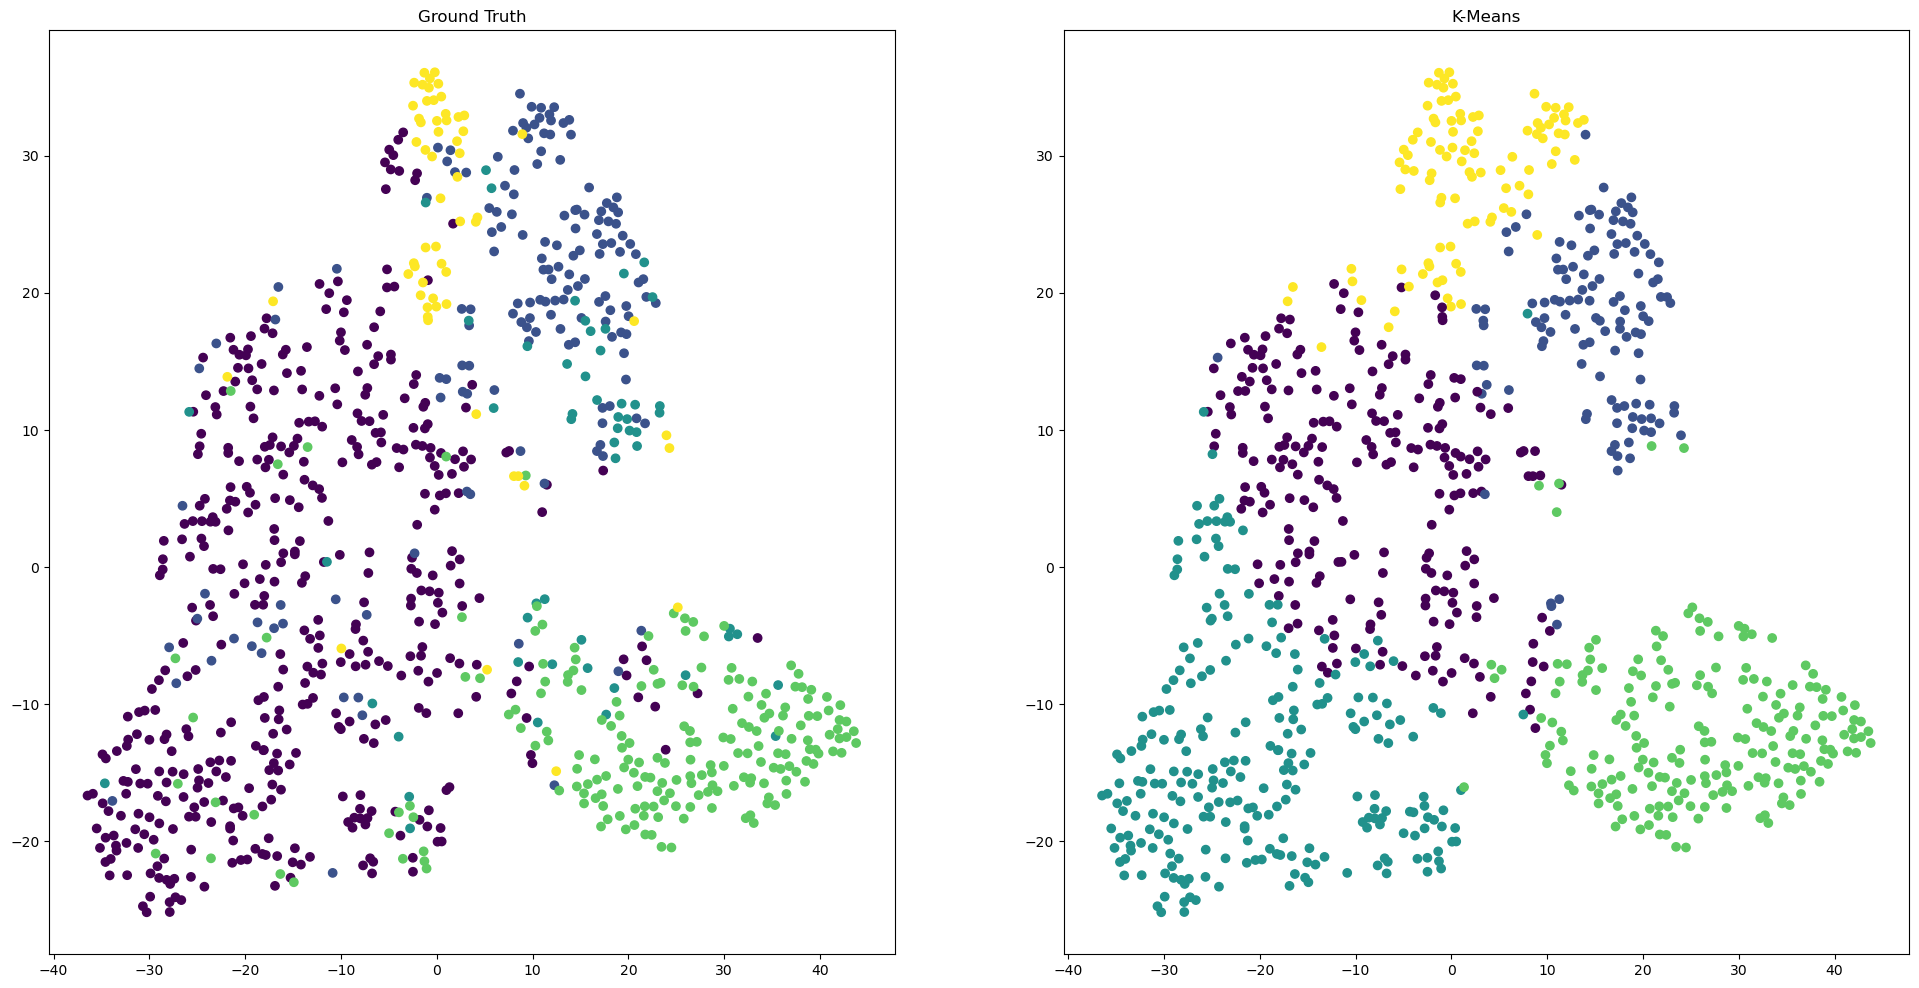

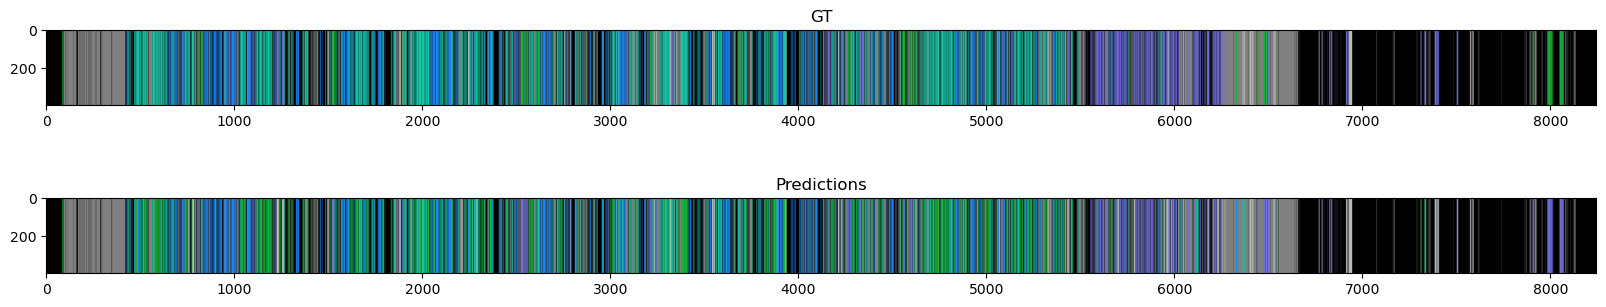

In [13]:
def eval_kmeans(embeddings, annotation, gt):
    # perfform clustering
    kmeans = KMeans(n_clusters=len(annotation['speakers']), random_state=4).fit(embeddings)
    kmeans_labels = kmeans.labels_

    # assign labels using the hungarian algorithm
    assigned_labels = assign_labels(gt, kmeans_labels)

    # compute t-sne on the embeddings for visualisation
    tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)

    fig = plt.figure(figsize=[24, 12])

    # t-sne with ground truth labels
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c=gt);
    ax.set_title('Ground Truth')
    # t-sne with cluster results
    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c=assigned_labels);
    ax.set_title('K-Means')

    fig, axes = plt.subplots(2, figsize=(20, 4))
    
    # coloured timeline with ground truth
    markup = draw_annotation(annotation)
    axes[0].imshow(markup)
    axes[0].set_title('GT')
    # coloured timeline with clustering results   
    markup = draw_predictions(assigned_labels, annotation)
    axes[1].imshow(markup)
    axes[1].set_title('Predictions')

# get the testing set
testing_bed008, labels_bed008 = get_testing_set(annotation_bed008, segments_bed008)
# get the embeddings
embeddings_bed008 = base_network.predict(testing_bed008, verbose=False)
# do the diarisation
eval_kmeans(embeddings_bed008, annotation_bed008, labels_bed008)

From the above, we see we've done ok. Our results are far from perfect, but we have managed to get some speakers pretty correct. One thing to observe is the very clear boundaries we are seeing in the t-sne plot for the clustering results (there are a few points that overlap due to the the dimension loss here - but generally we see very clear separation). This is the nature of K-means, we have clusters with uniform size and shape, and with hard boundaries between them. 

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


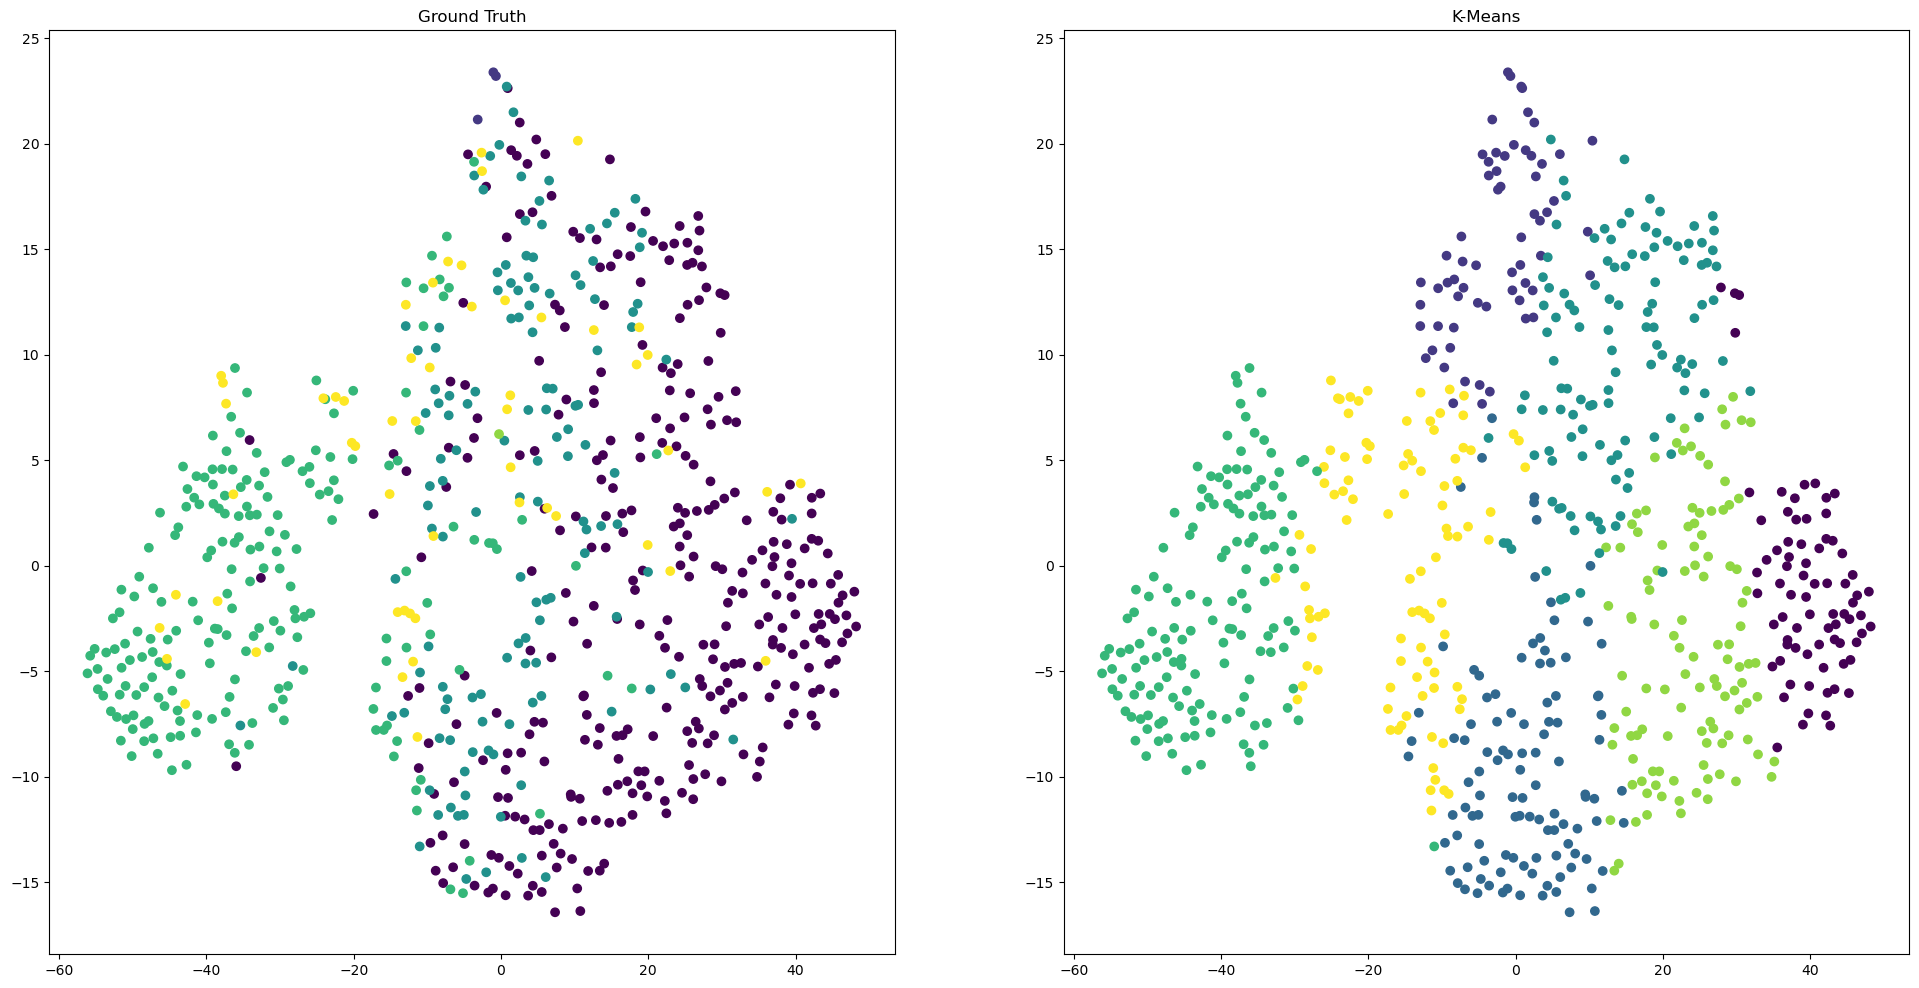

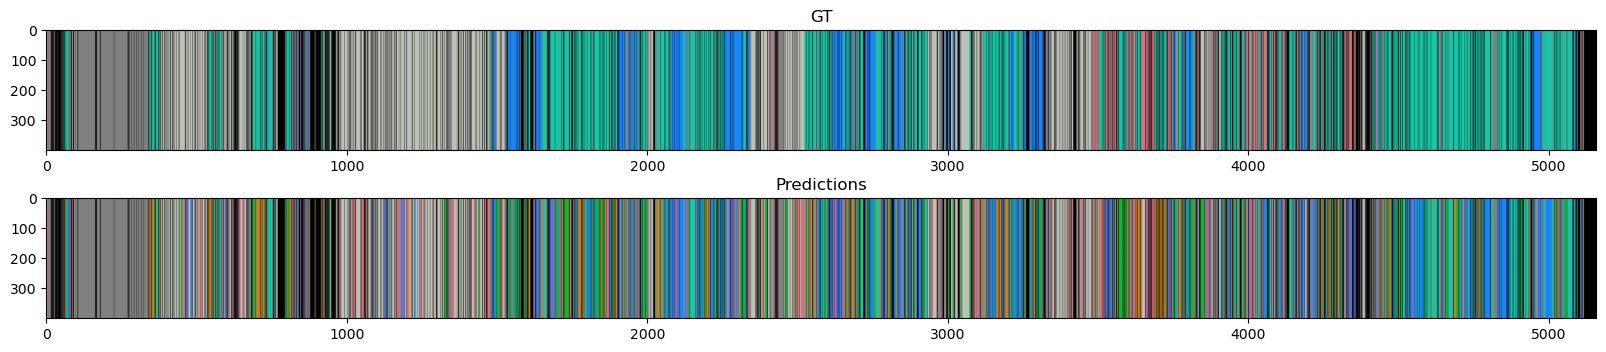

In [14]:
# get the testing set
testing_bed009, labels_bed009 = get_testing_set(annotation_bed009, segments_bed009)
# get the embeddings
embeddings_bed009 = base_network.predict(testing_bed009, verbose=False)
# do the diarisation
eval_kmeans(embeddings_bed009, annotation_bed009, labels_bed009)

Running this for our second test set, we get less good results. We see more overlap in the ground truth t-sne plot, and less agreement between the ground truth and the clustering. Some speakers are recognised kind-of ok - but on the whole performance is limited. 

One likely reason for this is the limitations of our backbone network. This network has been trained with limited data, and few speakers. It may well be that the speakers in our first test set were also in the training set, and here they are not. As such, the model struggles.

#### GMM

Let's try a GMM now. The process here is going to be much the same as for K-means, with the only difference that I will not also mark up points where the GMM is not super confident of the cluster assignment.

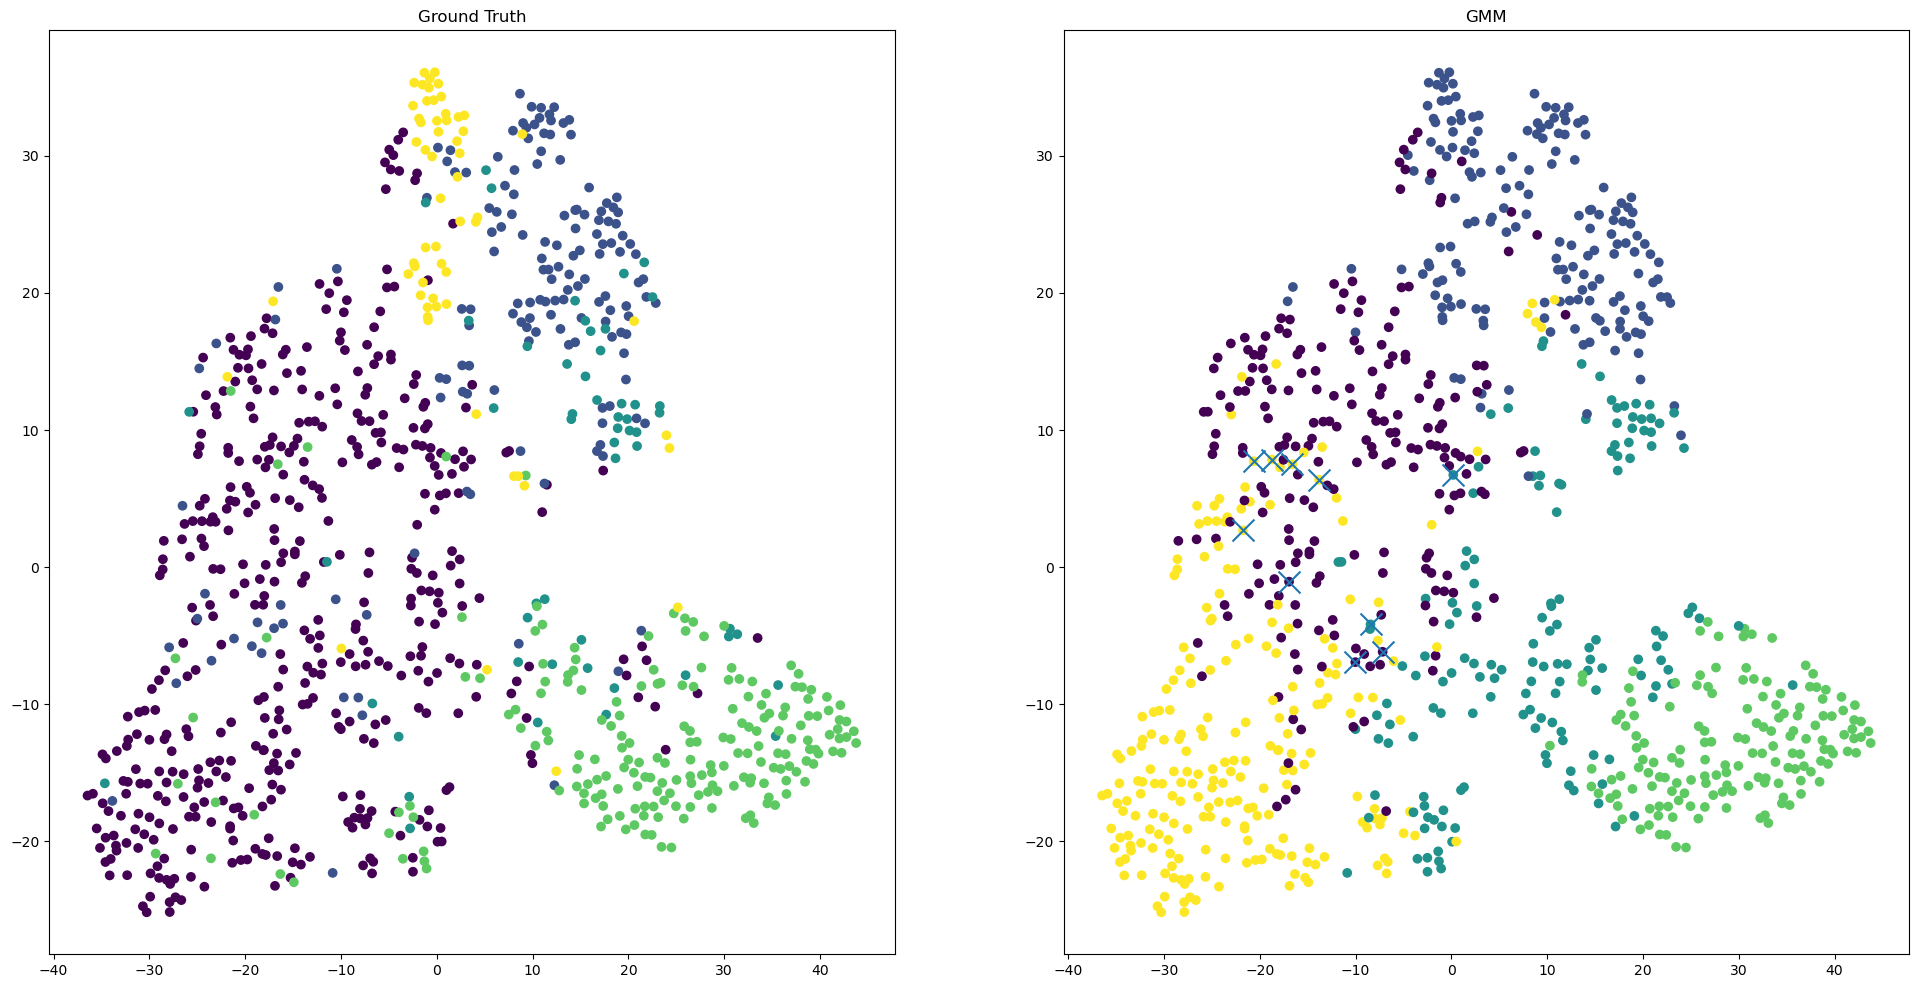

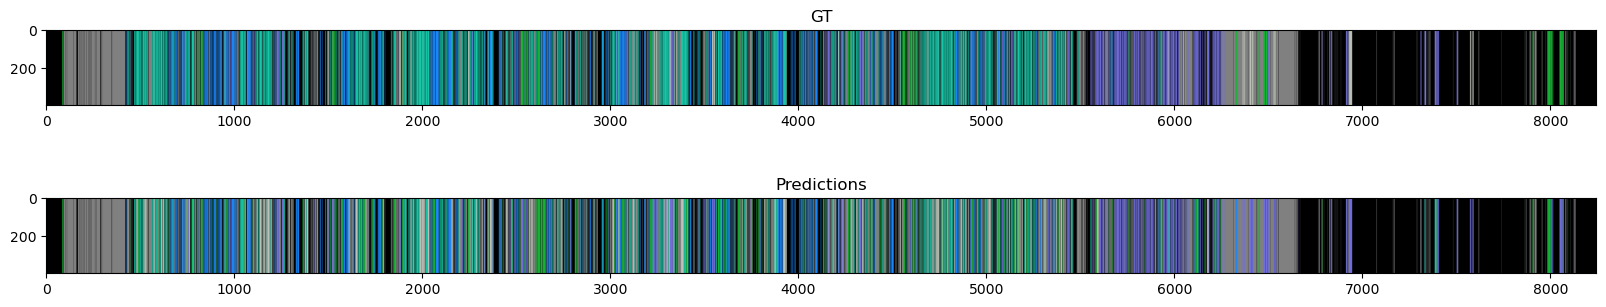

In [15]:
def eval_gmm(embeddings, annotation, gt, conf_threshold = 0.95):
    # fit the GMM and get the predictions
    gmm = GaussianMixture(len(annotation['speakers']), random_state=4).fit(embeddings)
    gmm_labels = gmm.predict(embeddings)

    # compute assignment using the hungarian algorithm
    assigned_labels = assign_labels(gt, gmm_labels)

    # get t-sne embeddings
    tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
    
    fig = plt.figure(figsize=[24, 12])
    # plot t-sne for the ground truth
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c=gt);
    ax.set_title('Ground Truth')
    # plot t-sne for the clustering results    
    ax = fig.add_subplot(1, 2, 2)
    a = gmm.predict_proba(embeddings)
    # find points where the confidence is a little lower, and mark these with an x
    uncertain_points = numpy.max(a, axis=1) < 0.95
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c=assigned_labels);
    ax.scatter(tsne_embeddings[uncertain_points,0], tsne_embeddings[uncertain_points,1], marker='x', s=250)   
    ax.set_title('GMM')

    fig, axes = plt.subplots(2, figsize=(20, 4))
    # plot the timeline for the ground truth
    markup = draw_annotation(annotation)
    axes[0].imshow(markup)
    axes[0].set_title('GT')
    # plot the timeline for the diarisation results    
    markup = draw_predictions(assigned_labels, annotation)
    axes[1].imshow(markup)
    axes[1].set_title('Predictions')
    
# evaluate the GMM, test set and embeddings were already computed for K-means, so no need to re-run
eval_gmm(embeddings_bed008, annotation_bed008, labels_bed008)

Compared to K-means, we see more variation in cluster size and shape, and the resulting clusters are generally more reflective of the data. We also see the *uncertain* points falling within the middle of the distribution, where all the classes somewhat overlap in the ground truth.

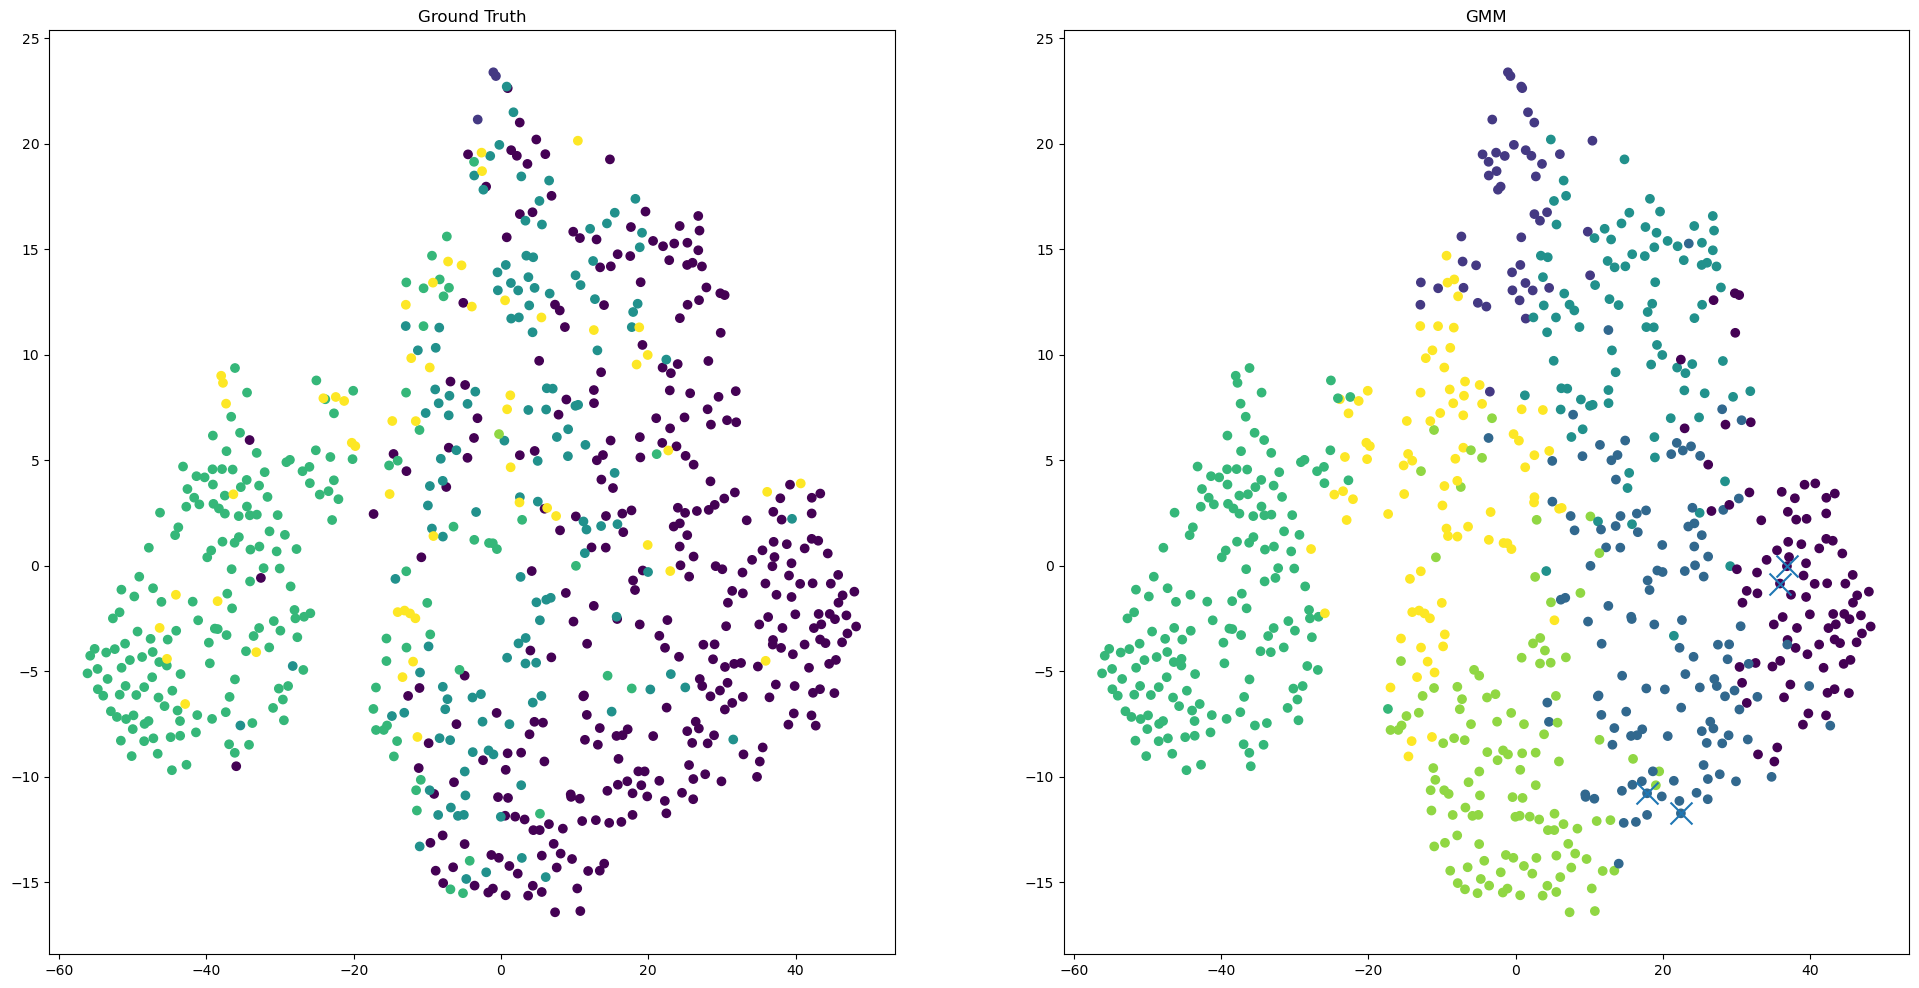

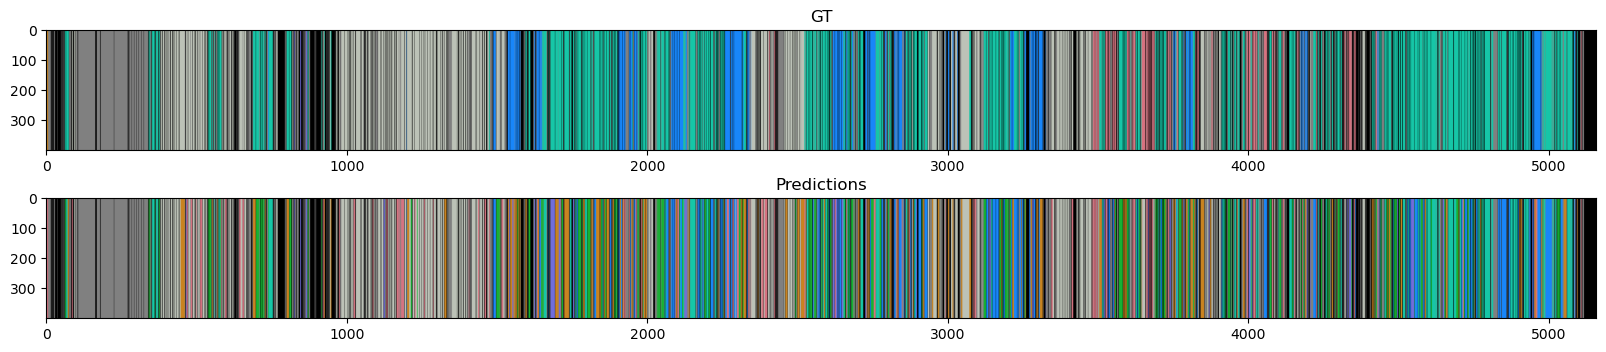

In [16]:
# evaluate the GMM, test set and embeddings were already computed for K-means, so no need to re-run
eval_gmm(embeddings_bed009, annotation_bed009, labels_bed009)

For our second example, we see a similar difference again between K-means and the GMM. The GMM gives us more varied cluster sizes and shapes, and the points that are uncertain lie in regions where classes overlap. Though we're still limited here by the (I assume) poor performance of the speaker recognition model, and overall diarisation results remain unspectacular.

## Final Thoughts

This example has hopefully provided a look at another application of clustering and metric learning. Remember that in this example, we've made a few simplications (using ground truth data to pull our segments of speech, taking just the first second of each bit of speech), and also used a very small dataset.

In practice, a much larger dataset would be used to train the speaker model, and we would consider other clustering methods from outside of the two core CAB420 methods for the diarisation (HAC is a popular option for this application).